### RQ3（仮）どれくらいの期間でSATDが除去されるのか？

In [1]:
from setting import PATH_OF_UNIQUE_SATD_INFO, PATH_OF_ALLPROJECT_CSV, PATH_OF_GITCLONE
from tqdm import tqdm
import os
import re
import pandas as pd
from datetime import datetime
import subprocess

In [2]:
df = pd.read_csv("./a-extractComment/SATDDeletedWithInfo.csv", index_col=0)
df.head()

,project,gitPath,CommitID,Deleted CommitID,Author,Delete Author,LatestDockerfile,Comment,CommitDate,DeleteComment,(File) FirstCommit,(File) Deleted,firstCommitからコメント追加までの日数,コメント追加からコメント削除までの日数,追加時ファイル,削除時ファイル,(origin)追加時ファイル,(origin)SATD
313,wikimedia\nmediawiki-docker,https://github.com/wikimedia/mediawiki-docker,4b8cc73503e4fadd6f2b01eba840fa787a0d0ee3,b48d43686790d3497fec7a7607d640f9b8c43d67,Gabriel Wicke <gwicke@wikimedia.org>,David Barratt <dbarratt@wikimedia.org>,1.31/apache/Dockerfile,# Extensions\n # TODO: make submodules ...,2015/12/19 10:41,2017/08/05 02:00,2015/08/13 14:16,NaN,"127 days, 20:25:00","594 days, 15:19:00",https://github.com/wikimedia/mediawiki-docker/...,https://github.com/wikimedia/mediawiki-docker/...,https://github.com/wikimedia/mediawiki-docker/...,# VisualEditor\n # TODO: make submodule...
178,31z4\nzookeeper-docker,https://github.com/31z4/zookeeper-docker,15b6f73b9f36a8bf4960c661427ac41de49cf534,2ac61a0d18eb23c113c38a57380548a000768cb7,Duncan Schulze <duncan.schulze@sonian.net>,Duncan Schulze <dschulze@barracuda.com>,3.5.8/Dockerfile,# TODO: the distribution given by apache i...,2017/10/24 14:12,2018/06/01 00:36,2017/10/24 14:12,NaN,0 days 00:00:00.000000000,"219 days, 10:24:00",https://github.com/31z4/zookeeper-docker/commi...,https://github.com/31z4/zookeeper-docker/commi...,NaN,NaN
255,rocker-org\nrocker,https://github.com/rocker-org/rocker,a35c1df7e3dced0956cc4c33fd32ef71a443d8c4,1617fbefba8f6e7cdbbfcdfb6f77c5653249ecb2,Carl Boettiger <cboettig@gmail.com>,Carl Boettiger <cboettig@gmail.com>,rstudio/testing/Dockerfile,## hack to avoid RStudio-bug in detecting bu...,2016/12/22 03:57,2016/12/23 00:55,2016/11/12 15:45,NaN,39 days 12:12:00.000000000,20:58:00,https://github.com/rocker-org/rocker/commit/a3...,https://github.com/rocker-org/rocker/commit/16...,NaN,NaN
121,docker\ndocker-ce,https://github.com/docker/docker-ce,2a1e2c7de1d97b0f8123e0e7d0cd79d4efa10c80,7fe655caac4b56da0004a5a7c52765b7e09aef1f,Tibor Vass <tibor@docker.com>,Antonio Murdaca <runcom@redhat.com>,components/engine/Dockerfile,# !!! TEMPORARY HACK !!!\n# Because of https:/...,2016/04/16 10:00,2016/05/25 18:58,2013/07/09 13:30,NaN,1011 days 20:30:00.000000000,"39 days, 8:58:00",https://github.com/docker/docker-ce/commit/2a1...,https://github.com/docker/docker-ce/commit/7fe...,NaN,NaN
139,docker\ndocker-ce,https://github.com/docker/docker-ce,7a1680b13a4d40f402fb54bfef604e8539c37662,dd52c68ae4d8dbcbb34a4ba7983eb160dbfe37fc,Brett Randall <javabrett@gmail.com>,Brian Goff <cpuguy83@gmail.com>,components/engine/Dockerfile,# # Make a dockerd binary.\n# # hack/make.sh b...,2018/02/14 20:08,2019/10/04 06:07,2013/07/09 13:30,NaN,"1681 days, 6:38:00","596 days, 9:59:00",https://github.com/docker/docker-ce/commit/7a1...,https://github.com/docker/docker-ce/commit/dd5...,https://github.com/docker/docker-ce/commit/1d5...,# # Make a dockerd binary.\n# # hack/make.sh b...


In [3]:
def daterange_to_minute(d):
    if "days," in d:
        days_time = d.split(" days, ")
        days = days_time[0]
        time = days_time[1].split(":")
        return int(days)*24*60 + int(time[0])*60 + int(time[1])
    elif "day," in d:
        days_time = d.split(" day, ")
        days = days_time[0]
        time = days_time[1].split(":")
        return int(days)*24*60 + int(time[0])*60 + int(time[1])
    else:
        time = d.split(":")
        return int(time[0])*60 + int(time[1])
    
    
df["コメント追加からコメント削除までの日数"] = df["コメント追加からコメント削除までの日数"].apply(lambda dt: daterange_to_minute(dt))

In [4]:
# 削除期間を保持する配列
deleted_terms = []

unique_satds = df["Comment"].unique()

for satd in unique_satds:
    tmp = df[df["Comment"] == satd]
    tmp = tmp.sort_values("コメント追加からコメント削除までの日数")
    deleted_terms.append(tmp.iloc[-1, :]["コメント追加からコメント削除までの日数"])

In [5]:
# 単位: minutes
deleted_terms

[856279,
 315984,
 1258,
 56698,
 858839,
 27,
 338532,
 13738,
 289579,
 274460,
 734772,
 749749,
 598201,
 1048633,
 2,
 25,
 61995,
 554263,
 198313,
 275279,
 0,
 297679,
 320716,
 149754,
 1972,
 149754,
 2374472,
 10066,
 982764,
 326524,
 20,
 1972,
 522899,
 130899,
 326524,
 18737,
 46,
 198313,
 25900,
 409146,
 167,
 730724,
 49038,
 158078,
 158078,
 50615,
 21749,
 0,
 20,
 146443,
 34579,
 1972,
 10396,
 1098423,
 91926,
 251756,
 31406]

## グラフ化

In [6]:
import os, re
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

In [7]:
deleted_terms_hour = list(map(lambda m: m//60, deleted_terms))

deleted_terms_day = list(map(lambda m: m//60//24, deleted_terms))

In [8]:
# 時間(hour)
term_hour_df = pd.DataFrame(deleted_terms_hour, columns=["削除されるまでの期間 (hour)"])
term_hour_df.describe()

,削除されるまでの期間 (hour)
count,57.000000
mean,4768.561404
std,6904.226255
min,0.000000
25%,173.000000
50%,2495.000000
75%,5442.000000
max,39574.000000


In [9]:
# 時間(day)
term_day_df = pd.DataFrame(deleted_terms_day, columns=["削除されるまでの期間 (day)"])
term_day_df.describe()

,削除されるまでの期間 (day)
count,57.000000
mean,198.263158
std,287.585858
min,0.000000
25%,7.000000
50%,103.000000
75%,226.000000
max,1648.000000


In [10]:
# pd.Series(deleted_terms).hist(figsize=(15, 3), bins=np.logspace(1, 5, 41, base=10));
# plt.title("ALL project")
# plt.ylabel('projects')
# plt.xlabel('revisions')
# plt.xscale('log')
# plt.yticks(range(0, 20, 2))
# plt.show()

### hour

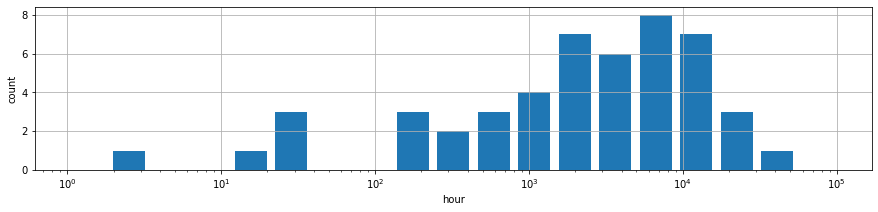

In [11]:
pd.Series(deleted_terms_hour).hist(figsize=(15, 3), bins=np.logspace(0, 5, 20, base=10), rwidth=0.8);
plt.title('')
plt.ylabel('count')
plt.xlabel('hour')
plt.xscale('log')
plt.show()

### day

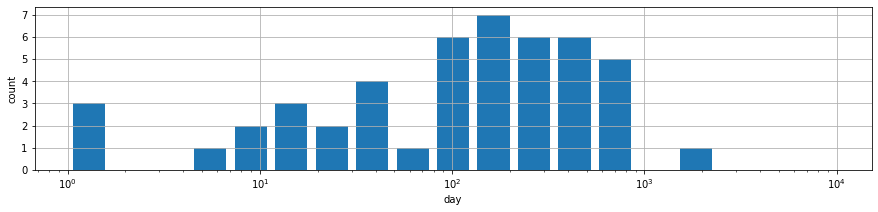

In [12]:
pd.Series(deleted_terms_day).hist(figsize=(15, 3), bins=np.logspace(0, 4, 20, base=10), rwidth=0.8);
plt.title('')
plt.ylabel('count')
plt.xlabel('day')
plt.xscale('log')
plt.show()